In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [3]:
%load_ext autoreload
%autoreload 2
from TileEM import *
from Qj_pTprime_models import *

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "../ipynb/shellAlg.png")

In [5]:
from TileEM import *
from adjacency import *

In [6]:
def find_all_tk_in_shell(tiles,current_shell_idx,exclude_idx=[]):
    # Find all tiles at the shell d=d+1
    # add all tiles adjacent to currentShell front 
    filtered_tidxs = np.delete(np.arange(len(tiles)),exclude_idx)
    
    adjacent_tkidxs =[]
    for ctidx in current_shell_idx:
        ck = tiles[ctidx]
        for tkidx in filtered_tidxs:
            tk = tiles[tkidx]
            if adjacent(tk,ck):
                adjacent_tkidxs.append(tkidx)
    # There might be a lot of duplicate tiles that is adjacent to more than one tile on the current shell front
    return list(set(adjacent_tkidxs))

In [ ]:
# def safe_add_log(p,q):
#     '''
#     p=p+np.log(q)
#     '''
#     pInT+=np.log(1-qp2)
#     pNotInT+=np.log(qn2)
#     np.log(qp1)

In [49]:
def core(tiles,indMat,topk=1):
    # In the initial step, we pick T to be the top 5 area-vote score
    # where we combine the area and vote in a 1:5 ratio
    area = np.array(indMat[-1])
    votes =indMat[:-1].sum(axis=0)
    norm_area_vote = area/max(area)+5*votes/max(votes)
    tidx = np.argsort(norm_area_vote)[::-1][:topk]
    return join_tiles(tidx,tiles)[0],list(tidx)

In [75]:
def initT(tiles,indMat):
    # In the initial step, 
    # pick the tiles that at least 50% of the workers have voted on
    votes =indMat[:-1].sum(axis=0)
    Nworkers = shape(indMat)[0]
    tidx =np.where(votes>Nworkers/2.)[0]
    return join_tiles(tidx,tiles)[0],list(tidx)

In [52]:
tiles=pkl.load(open("output_15/vtiles{}.pkl".format(objid)))

In [64]:
indMat=pkl.load(open("output_15/indMat{}.pkl".format(objid)))
workers=pkl.load(open("output_15/worker{}.pkl".format(objid)))

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 91.449367088607588 359.46202531645565 at 91.449367088607588 359.46202531645565
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (65 413, 68.5 413.833) and LINESTRING (68.5 413.833, 56 408) at 68.499999999999986 413.83333333333331
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (76.6943 334.123, 70.8 330.4) and LINESTRING (70.8 330.4, 77.6902 334.752) at 73.034136727028169 331.8110337223336
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.

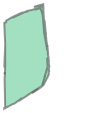

In [74]:
join_tiles(tidx,tiles)[0]

In [76]:
def runTileAdjacentMLConstruction(objid,workerErrorfunc,Qjfunc,A_percentile,Niter=10,DEBUG=False,PLOT_LIKELIHOOD=False,PLOT=False):
#     ##########
#     PLOT=True
#     DATA_DIR="output_15"
#     objid=3
#     workerErrorfunc="GTLSA"
#     Qjfunc=QjGTLSA
#     A_percentile=90
#     Niter=100
#     DEBUG=True
#     PLOT_LIKELIHOOD=False
#     ##########
    #Initilaize with majority vote tile , get good Qj estimates based on that 
    # ML Construction with E step as usual 
    tiles = pkl.load(open(DATA_DIR+"/vtiles{}.pkl".format(objid)))
    indMat = pkl.load(open(DATA_DIR+"/indMat{}.pkl".format(objid)))
    workers = pkl.load(open(DATA_DIR+"/worker{}.pkl".format(objid)))

    tile_area = np.array(indMat[-1])
    A_thres = np.percentile(tile_area,A_percentile)
    Qj_lst=[]
    #if DEBUG: print "Coming up with T' combinations to search through"
    #Tprime_lst, Tprime_idx_lst = Tprimefunc(objid,tiles,indMat,fixedtopk=3, topk = 40,NTprimes=NTprimes)
    Tstar_lst = []
    Tstar_idx_lst =[]
    likelihood_lst=[]

    if DEBUG: print "Compute Core Tiles"
    Tstar,Tidx=core(tiles,indMat,1)
    Tstar_lst.append([Tstar])
    Tstar_idx_lst.append(Tidx)

    if DEBUG: print "Initialize Tiles"
    Tinit,Iidx=initT(tiles,indMat)
    if DEBUG: print "Estimate based on initial tileset and get good Qjs"
    Qjhat = estimate_Qj(Tinit,tiles,indMat,workers,Qjfunc,A_percentile,DEBUG=DEBUG)
    Qn1,Qn2,Qp1,Qp2 = zip(*Qjhat)
    
    for i in tqdm(range(Niter)):
        if DEBUG: print "Iteration #", i
        plk=0
        if i!=0:
            if DEBUG: print "E-step : Estimate Qj parameters"
            Qjhat = estimate_Qj(Tstar_lst[i][0],tiles,indMat,workers,Qjfunc,A_percentile,DEBUG=DEBUG)
            Qn1,Qn2,Qp1,Qp2 = zip(*Qjhat)

        if DEBUG: print "ML construction of Tstar"
        dPrime = 0

        exclude_idx = set(Tstar_idx_lst[0])
        Tidx_lst = list(exclude_idx)
        good_dPrime_tcount = len(exclude_idx)
        current_shell_tkidxs= Tidx
        past_shell_tkidxs= Tidx
        if DEBUG: print "Add core tiles to first occurence of tk satisfying criterion"
        Tstar_lst.append([Tstar_lst[0][0]])
        while (good_dPrime_tcount!=0 or len(current_shell_tkidxs)!=0):
            ######
            print "Excluding",exclude_idx
            current_shell_tkidxs = find_all_tk_in_shell(tiles,past_shell_tkidxs,list(exclude_idx))

            if DEBUG: 
                print "d'={0}; good_dPrime_tcount={1}".format(dPrime,good_dPrime_tcount)
                print "Number of tks in shell: ",len(current_shell_tkidxs)
                print "Current shell index:",current_shell_tkidxs
            good_dPrime_tcount=0

            for k in current_shell_tkidxs:
                pInT = 0
                pNotInT = 0
                tk = tiles[k]
                # Compute pInT and pNotInT
                for j in range(len(workers)):
                    ljk = indMat[j][k] #NOTE k doesn't correspond to k in tiles but in current_shell_tks so this is not good
                    wid=workers[j] 
                    qp1 = Qp1[j]
                    qp2 = Qp2[j]
                    qn1 = Qn1[j]
                    qn2 = Qn2[j]
                    
                    if tk.area>A_thres:
                        if ljk ==1:
                            if qp1!=-1:
                                pInT+=np.log(qp1)
                            if qn1!=-1:
                                pNotInT+=np.log(1-qn1)
                        else:
                            if qp1!=-1:
                                pInT+=np.log(1-qp1)
                            if qn1!=-1:
                                pNotInT+=np.log(qn1)
                    else:
                        if ljk ==1:
                            if qp2!=-1:
                                pInT+=np.log(qp2)
                            if qn2!=-1:
                                pNotInT+=np.log(1-qn2)
                        else:
                            if qp2!=-1:
                                pInT+=np.log(1-qp2)
                            if qn2!=-1:
                                pNotInT+=np.log(qn2)
                # Check if tk satisfy constraint
                if pInT<pNotInT:
                    plk+=pNotInT
                elif pInT>=pNotInT:
                    plk+=pInT 
                    # if satisfy criterion, then add to Tstar
                    good_dPrime_tcount+=1
                    if DEBUG: print "Adding tk",k
                    try:
                        Tstar_lst[i]=[Tstar_lst[i][0].union(tk)]
                        Tidx_lst.append(k)
                    except(shapely.errors.TopologicalError):
                        try:
                            Tstar_lst[i]=[Tstar_lst[i][0].buffer(0).union(tk.buffer(-1e-10))]
                            Tidx_lst.append(k)
                        except(shapely.errors.TopologicalError):
                            try:
                                Tstar_lst[i]=[Tstar_lst[i][0].buffer(-1e-10).union(tk)]
                                Tidx_lst.append(k)
                            except(shapely.errors.TopologicalError):
                                try:
                                    Tstar_lst[i]=[Tstar_lst[i][0].buffer(-1e-10).union(tk.buffer(-1e-10))]
                                    Tidx_lst.append(k)
                                except(shapely.errors.TopologicalError):
                                    try:
                                        Tstar_lst[i]=[Tstar_lst[i][0].union(tk.buffer(1e-10))]
                                        Tidx_lst.append(k)
                                    except(shapely.errors.TopologicalError):
                                        try:
                                            Tstar_lst[i]=[Tstar_lst[i][0].buffer(1e-10).union(tk)]
                                            Tidx_lst.append(k)
                                        except(shapely.errors.TopologicalError):
                                            try:
                                                Tstar_lst[i]=[Tstar_lst[i][0].buffer(1e-10).union(tk.buffer(1e-10))]
                                                Tidx_lst.append(k)
                                            except(shapely.errors.TopologicalError):
                                                print "Shapely Topological Error: unable to add tk, Tstar unchanged; at k=",k
                                                pkl.dump(Tstar_lst[i][0],open("problematic_Tstar_{0}.pkl".format(k),'w'))
                                                pkl.dump(tk,open("problematic_tk_{0}.pkl".format(k),'w'))
                                                pass

            ############################################################################################################
            if PLOT:
                plt.figure()
                for c in current_shell_tkidxs:plot_coords(tiles[c],color="red",fill_color="red") #current front
                for c in past_shell_tkidxs:plot_coords(tiles[c],color="cyan",linewidth=5,linestyle='--') #past front
                for c in exclude_idx:plot_coords(tiles[c],color="gray",fill_color="gray")#excluded coord
                plot_coords(Tstar_lst[i][0],linestyle="--",linewidth=2,color="blue")#current Tstar
                for c in Tidx_lst:plot_coords(tiles[c],linewidth=2,color="green",fill_color="green")#new Tstar
                plt.ylim(40,100)


            
            #Updates
            Tstar = Tstar_lst[i][0].buffer(0)
            dPrime+=1
            past_shell_tkidxs= current_shell_tkidxs
            exclude_idx= exclude_idx.union(current_shell_tkidxs)
        
    
        #Storage
        Qj_lst.append(Qjhat)
        Tstar_idx_lst.append(Tidx_lst)
        likelihood_lst.append(plk)

    return Tstar_idx_lst , likelihood_lst, Qj_lst,Tstar_lst

In [77]:
DATA_DIR="output_15"
exp_num=19
print "Running experiment #",exp_num
objid=3
end = time.time()
Tstar_idx_lst ,likelihood_lst,Qj_lst,Tstar_lst=runTileAdjacentMLConstruction(objid,workerErrorfunc="GTLSA",Qjfunc=QjGTLSA,A_percentile=90,Niter=10,DEBUG=True,PLOT_LIKELIHOOD=False)
pkl.dump(likelihood_lst,open("likelihood_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Tstar_lst,open("Tstar_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Tstar_idx_lst,open("Tstar_idx_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
pkl.dump(Qj_lst,open("Qj_exp{0}_obj{1}.pkl".format(exp_num,objid),'w'))
end2 = time.time()
print "Time Elapsed: ",end2-end

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 91.449367088607588 359.46202531645565 at 91.449367088607588 359.46202531645565
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (65 413, 68.5 413.833) and LINESTRING (68.5 413.833, 56 408) at 68.499999999999986 413.83333333333331
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (76.6943 334.123, 70.8 330.4) and LINESTRING (70.8 330.4, 77.6902 334.752) at 73.034136727028169 331.8110337223336
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 72.75 331.375) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.

Running experiment # 19
Compute Core Tiles
Initialize Tiles
Estimate based on initial tileset and get good Qjs

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 66.1622 327.068) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272726712 338.90909090909054
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (87.2817 344.577, 86.0132 340.047) and LINESTRING (86.3527 341.26, 87.0543 343.765) at 86.751444443346287 342.68373015480813
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (61.1538 324.308, 60.6667 324) and LINESTRING (60.6667 324, 60.6667 324) at 60.666666666666558 323.99999999999994
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.6667 324, 60.6667 324) and LINESTRING (59.9444 323.544, 60.6667 324) at 60.666666666666394 323.99999999999983
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (50 318.111, 51.8571 319.143) and LINESTRING (51.8571 319.143, 50 318.4) at 51.857142857142


Qj: 

  0%|          | 0/10 [00:00<?, ?it/s]

 [(0.7272727272727273, 0.5963302752293578, 0.6666666666666666, 0.4166666666666667), (0.5454545454545454, 0.3486238532110092, 1.0, 0.75), (0.18181818181818182, 0.4036697247706422, 1.0, 0.6666666666666666), (0.5454545454545454, 0.5504587155963303, 0.8333333333333334, 0.8333333333333334), (0.36363636363636365, 0.46788990825688076, 0.6666666666666666, 0.6944444444444444), (0.45454545454545453, 0.6238532110091743, 1.0, 0.7777777777777778), (0.45454545454545453, 0.44954128440366975, 0.5, 0.75), (0.8181818181818182, 0.6788990825688074, 0.8333333333333334, 0.5833333333333334), (0.45454545454545453, 0.30275229357798167, 1.0, 0.9166666666666666), (0.18181818181818182, 0.5229357798165137, 1.0, 0.7222222222222222)]
Iteration # 0
ML construction of Tstar
Add core tiles to first occurence of tk satisfying criterion
Excluding set([68])
d'=0; good_dPrime_tcount=1

ERROR:shapely.geos:TopologyException: no outgoing dirEdge found at 91.449367088607588 359.46202531645565



Number of tks in shell:  54
Current shell index: [128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 147, 69, 70, 71, 78, 156, 85, 86, 87, 153, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 115, 116, 117, 120, 122]
Adding tk 128
Adding tk 129
Adding tk 131
Adding tk 140
Adding tk 141
Adding tk 15
Adding tk 144
Adding tk 17
Adding tk 148
Adding tk 149
Adding tk 150
Adding tk 151
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (86.1342 340.479, 86.3495 341.248) and LINESTRING (86.0132 340.047, 86.8487 343.031) at 86.159305132533717 340.56894690190609


 152
Adding tk 25
Adding tk 154
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (72.9655 414.897, 72.9655 414.897) and LINESTRING (72.9655 414.897, 72.9655 414.897) at 72.965517241383083 414.89655172403798
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.4294 417.626, 75.0516 415.393) and LINESTRING (77.6 416, 72.9655 414.897) at 77.599418796855645 415.99986161829895


 27
Adding tk 28
Adding tk 157
Adding tk 158
Adding tk 31
Adding tk 160
Adding tk 161
Adding tk 40
Adding tk 43
Adding tk 45
Adding tk 49
Adding tk 147
Adding tk 69
Adding tk 70
Adding tk 78
Adding tk 156
Adding tk 85
Adding tk 86
Adding tk 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 99
Adding tk 100
Adding tk 102
Adding tk 106
Adding tk 110
Adding tk 111
Adding tk 112
Adding tk 114
Adding tk 115
Adding tk 116
Adding tk 117
Adding tk 120
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=49
Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 6

 10%|█         | 1/10 [00:04<00:40,  0.22it/s]


Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=0
Number of tks in shell:  0
Current shell index: []
Iteration # 1
E-step : Estimate Qj parameters


ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (51.8636 405.045, 51.8636 405.045) and LINESTRING (51.8636 405.045, 51.8636 405.045) at 51.863636363695107 405.04545454537362
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (70.775 414.375, 77.4575 415.966) and LINESTRING (72.9655 414.897, 72.9655 414.897) at 72.965517241379203 414.89655172413791


 70
Adding tk 71
Adding tk 78
Adding tk 85
Adding tk 86
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (86.5551 411.061, 86.5263 411.421) and LINESTRING (87.7143 407.857, 86.5263 411.421) at 86.526315789473713 411.42105263157885


 87
Adding tk 153
Adding tk 90
Adding tk 92
Adding tk 100
Adding tk 102
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 84.2727 338.909) and LINESTRING (84.2727 338.909, 84.2727 338.909) at 84.272727272727309 338.90909090909093


 106
Adding tk 110
Adding tk 111
Adding tk 112
Adding tk 113
Adding tk 114
Adding tk 115
Adding tk 116
Adding tk 117
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (77.6 416, 78.3636 416.182) and LINESTRING (78.3636 416.182, 78.3636 416.182) at 78.36363636363636 416.18181818181819


 120
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (91.2216 374.959, 91.2216 374.959) and LINESTRING (91.0859 375.719, 92 370.6) at 91.221649484536087 374.95876288659792


 122
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=46
Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 0
Adding tk 4
Adding tk 133
Adding tk 6
Adding tk 135
Adding tk 8
Adding tk 137
Adding tk 10
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (91.766 368.894, 92 367.333) and LINESTRING (92 366.286, 91.766 368.894) at 91.765957446808528 368.89361702127644


 139
Adding tk 12
Adding tk 13
Adding tk 142
Adding tk 143
Adding tk 16
Adding tk 145
Adding tk 146
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (74.4 331.6, 69.2496 328.947) and LINESTRING (74.25 331.523, 69.7602 329.21) at 71.858045582242724 330.29050833024627


 20
Adding tk 22
Adding tk 23
Adding tk 24
Adding tk 26
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (74.4 331.6, 68.8943 328.764) and LINESTRING (69.7602 329.21, 74.25 331.523) at 71.556564117138933 330.13519969670796


 155
Adding tk 5
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (89 348, 86.0191 340.051) and LINESTRING (86.0132 340.047, 86.0194 340.051) at 86.019108280314128 340.05095541417103


 159
Adding tk 32
Adding tk 33
Adding tk 34
Adding tk 35
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (87.566 341.019, 86.3853 339.937) and LINESTRING (85 338.667, 87.4615 340.923) at 86.79562236359844 340.31265383329855


 38
Adding tk 39
Adding tk 42
Adding tk 7
Adding tk 44
Adding tk 46
Adding tk 47
Adding tk 48
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (60.6667 324, 59.7643 323.323) and LINESTRING (58.2222 322.167, 60.6667 324) at 60.666666666666373 323.99999999999977


 50
Adding tk 54
Adding tk 55
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.6533 337.093, 82.5 337) at 82.500000000000639 337.0000000000004


 56
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (82.5 337, 82.7143 337.143) and LINESTRING (82.5 337, 82.6533 337.093) at 82.500000000000639 337.0000000000004


 57
Adding tk 59
Adding tk 60
Adding tk 138
Adding tk 62
Adding tk 63
Adding tk 64
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (50.3826 318.324, 50.6321 318.462) and LINESTRING (51.7561 319.087, 50 318.111) at 50.559333916637542 318.42185217590975


 66
Adding tk 67
Adding tk 72
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (54.9091 320.364, 51.8571 319.143) and LINESTRING (50 318.111, 53.0168 319.787) at 51.857142857142861 319.14285714285711


 73
Adding tk 75
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (74.4 331.6, 85 338.667) and LINESTRING (84.7615 338.448, 85 338.667) at 84.999999999999957 338.66666666666663


 76
Adding tk

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (89.457 394.623, 89.8975 389.713) and LINESTRING (89.7908 390.902, 89.7908 390.902) at 89.790849673202615 390.90196078431376


 77
Adding tk 80
Adding tk 81
Adding tk 82
Adding tk 83
Adding tk 84
Adding tk 88
Adding tk 89
Adding tk 91
Adding tk 95
Adding tk 96
Adding tk 97
Adding tk 9
Adding tk 105
Adding tk 107
Adding tk 108
Adding tk 109
Adding tk 118
Adding tk 119
Adding tk 124
Adding tk 125
Adding tk 126
Adding tk 127
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 98, 99, 100, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=2; good_dPrime_tcount=76
Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (48 356, 48.1233 359.205) and LINESTRING (48.1233 359.205, 48.1233 359.205) at 48.123287671232873 359.20547945205476


 21
Adding tk 30
Adding tk 36
Adding tk 37
Adding tk 51
Adding tk 52
Adding tk 53
Adding tk 58
Adding tk 61
Adding tk 65
Adding tk 74
Adding tk 79
Adding tk 93
Adding tk 94
Adding tk 101
Adding tk 103
Adding tk 104
Adding tk 121
Adding tk

 20%|██        | 2/10 [00:11<00:46,  0.17it/s]

 123
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=24
Number of tks in shell:  0
Current shell index: []
Iteration # 2
E-step : Estimate Qj parameters
Qj:  [(0.6666666666666666, 0.5971223021582733, 1.0, 0.5), (0.4, 0.3237410071942446, 1.0, 0.6666666666666666), (0.13333333333333333, 0.38848920863309355, 1

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 84.0385 338.761) and LINESTRING (84.0127 338.745, 84.2727 338.909) at 84.254131722721866 338.89734635119277


 100
Adding tk 102
Adding tk 110
Adding tk 111
Adding tk 112
Adding tk 114
Adding tk 116
Adding tk 117
Adding tk 120
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=34
Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 155
Adding tk 46
Adding tk 56
Adding tk 80
Adding tk 81
Adding tk 82
Adding tk 89
Adding tk 118
Adding tk 119
Adding tk 126
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 1

 30%|███       | 3/10 [00:34<01:20,  0.09it/s]


Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=0
Number of tks in shell:  0
Current shell index: []
Iteration # 3
E-step : Estimate Qj parameters


ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 84.0385 338.761) and LINESTRING (84.0127 338.745, 84.2727 338.909) at 84.254131722721866 338.89734635119277


 112
Adding tk 114
Adding tk 116
Adding tk 117
Adding tk 120
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=34
Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 155
Adding tk 46
Adding tk 56
Adding tk 80
Adding tk 81
Adding tk 82
Adding tk 89
Adding tk 118
Adding tk 119
Adding tk 126
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 3

 40%|████      | 4/10 [00:57<01:26,  0.07it/s]


Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=0
Number of tks in shell:  0
Current shell index: []
Iteration # 4
E-step : Estimate Qj parameters


ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 84.0385 338.761) and LINESTRING (84.0127 338.745, 84.2727 338.909) at 84.254131722721866 338.89734635119277


 112
Adding tk 114
Adding tk 116
Adding tk 117
Adding tk 120
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=34
Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 155
Adding tk 46
Adding tk 56
Adding tk 80
Adding tk 81
Adding tk 82
Adding tk 89
Adding tk 118
Adding tk 119
Adding tk 126
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 3

 50%|█████     | 5/10 [01:20<01:20,  0.06it/s]


Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=0
Number of tks in shell:  0
Current shell index: []
Iteration # 5
E-step : Estimate Qj parameters


ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 84.0385 338.761) and LINESTRING (84.0127 338.745, 84.2727 338.909) at 84.254131722721866 338.89734635119277


 102
Adding tk 110
Adding tk 111
Adding tk 112
Adding tk 114
Adding tk 116
Adding tk 117
Adding tk 120
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=34
Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 155
Adding tk 46
Adding tk 56
Adding tk 80
Adding tk 81
Adding tk 82
Adding tk 89
Adding tk 118
Adding tk 119
Adding tk 126
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22,

 60%|██████    | 6/10 [01:46<01:10,  0.06it/s]


Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=0
Number of tks in shell:  0
Current shell index: []
Iteration # 6
E-step : Estimate Qj parameters


ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 84.0385 338.761) and LINESTRING (84.0127 338.745, 84.2727 338.909) at 84.254131722721866 338.89734635119277


 112
Adding tk 114
Adding tk 116
Adding tk 117
Adding tk 120
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=34
Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 155
Adding tk 46
Adding tk 56
Adding tk 80
Adding tk 81
Adding tk 82
Adding tk 89
Adding tk 118
Adding tk 119
Adding tk 126
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 3

 70%|███████   | 7/10 [02:10<00:55,  0.05it/s]


Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=0
Number of tks in shell:  0
Current shell index: []
Iteration # 7
E-step : Estimate Qj parameters


ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 84.0385 338.761) and LINESTRING (84.0127 338.745, 84.2727 338.909) at 84.254131722721866 338.89734635119277


 112
Adding tk 114
Adding tk 116
Adding tk 117
Adding tk 120
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=34
Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 155
Adding tk 46
Adding tk 56
Adding tk 80
Adding tk 81
Adding tk 82
Adding tk 89
Adding tk 118
Adding tk 119
Adding tk 126
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 3

 80%|████████  | 8/10 [02:34<00:38,  0.05it/s]


Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=0
Number of tks in shell:  0
Current shell index: []
Iteration # 8
E-step : Estimate Qj parameters


ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 84.0385 338.761) and LINESTRING (84.0127 338.745, 84.2727 338.909) at 84.254131722721866 338.89734635119277


 99
Adding tk 100
Adding tk 102
Adding tk 110
Adding tk 111
Adding tk 112
Adding tk 114
Adding tk 116
Adding tk 117
Adding tk 120
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=34
Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 155
Adding tk 46
Adding tk 56
Adding tk 80
Adding tk 81
Adding tk 82
Adding tk 89
Adding tk 118
Adding tk 119
Adding tk 126
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 

 90%|█████████ | 9/10 [02:58<00:19,  0.05it/s]


Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=0
Number of tks in shell:  0
Current shell index: []
Iteration # 9
E-step : Estimate Qj parameters


ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (84.2727 338.909, 84.0385 338.761) and LINESTRING (84.0127 338.745, 84.2727 338.909) at 84.254131722721866 338.89734635119277


 112
Adding tk 114
Adding tk 116
Adding tk 117
Adding tk 120
Excluding set([128, 129, 131, 140, 141, 15, 144, 17, 19, 148, 149, 150, 151, 152, 25, 154, 27, 28, 157, 158, 31, 160, 161, 40, 41, 43, 45, 49, 115, 68, 69, 70, 71, 78, 120, 156, 85, 86, 87, 90, 92, 99, 100, 102, 106, 110, 111, 112, 113, 114, 147, 116, 117, 153, 122])
d'=1; good_dPrime_tcount=34
Number of tks in shell:  81
Current shell index: [0, 130, 3, 4, 133, 6, 135, 8, 137, 10, 139, 12, 13, 142, 143, 16, 145, 146, 20, 22, 23, 24, 26, 155, 5, 159, 32, 33, 34, 35, 38, 39, 42, 7, 44, 46, 47, 48, 136, 50, 54, 55, 56, 57, 59, 60, 138, 62, 63, 64, 66, 67, 72, 73, 75, 76, 77, 80, 81, 82, 83, 84, 14, 88, 89, 91, 95, 96, 97, 98, 9, 105, 107, 108, 109, 118, 119, 124, 125, 126, 127]
Adding tk 155
Adding tk 46
Adding tk 56
Adding tk 80
Adding tk 81
Adding tk 82
Adding tk 89
Adding tk 118
Adding tk 119
Adding tk 126
Excluding set([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 3


Number of tks in shell:  26
Current shell index: [1, 2, 132, 134, 11, 18, 21, 29, 30, 36, 37, 51, 52, 53, 58, 61, 65, 74, 79, 93, 94, 101, 103, 104, 121, 123]
Excluding set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])
d'=3; good_dPrime_tcount=0
Number of tks in shell:  0
Current shell index: []
Time Elapsed:  224.075325012


A lot of tiles are getting added after we make the QJ!=-1 fix so this is good! 

In [34]:
from MLConstructionExperiment import *

Qn1,Qn2,Qp1,Qp2
blue green red cyan 

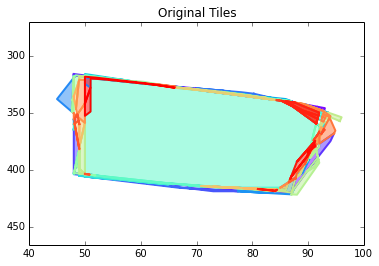

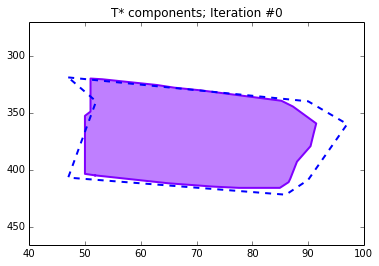

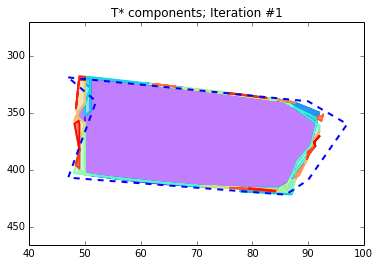

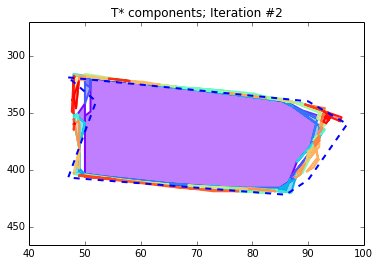

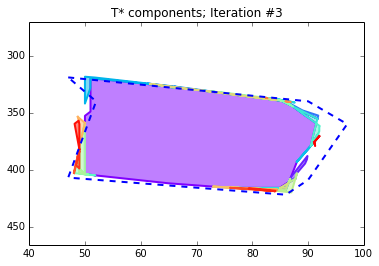

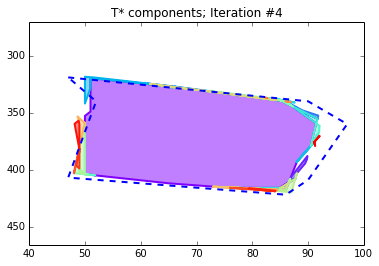

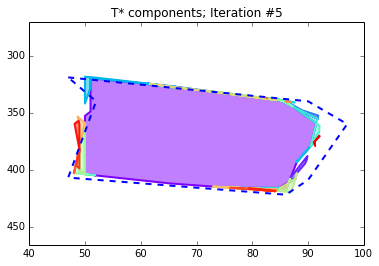

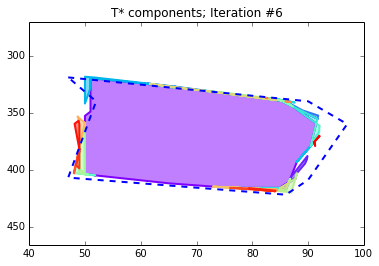

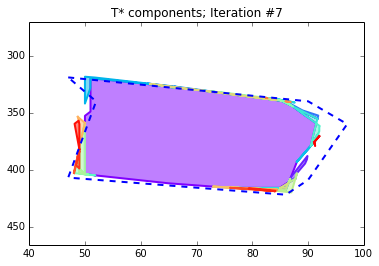

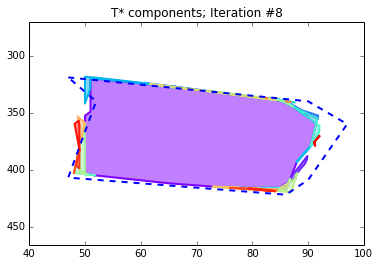

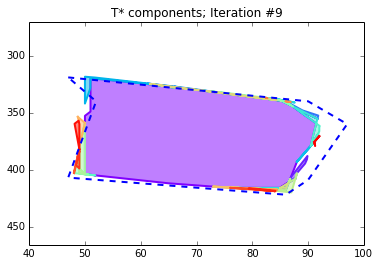

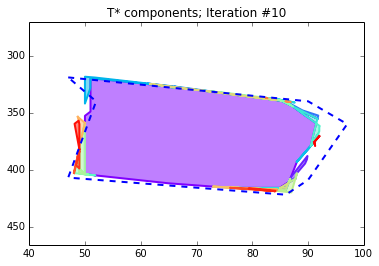

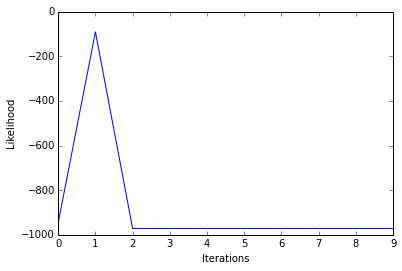

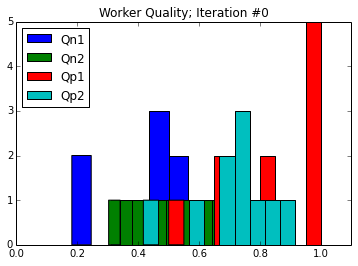

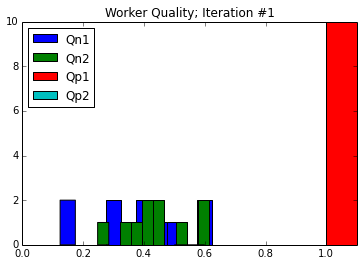

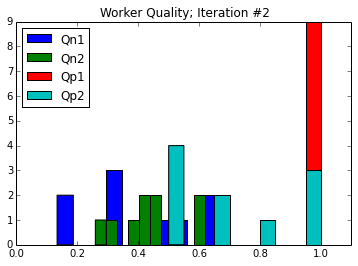

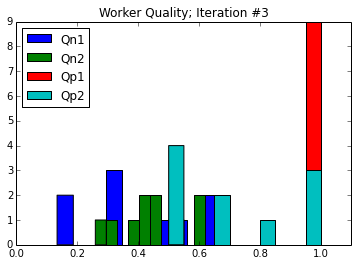

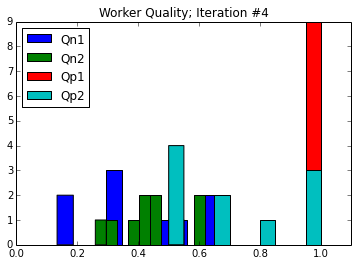

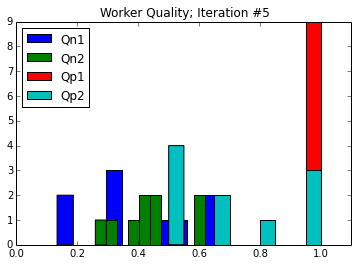

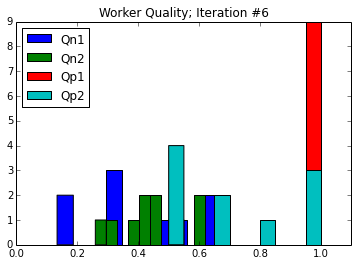

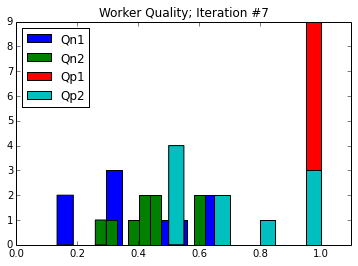

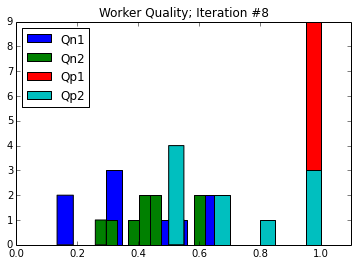

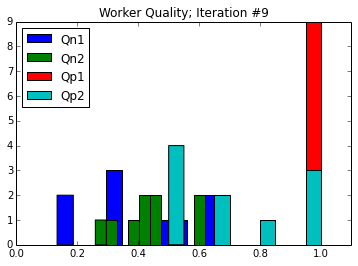

In [78]:
run_all_experiment_plots(3,19,1)

- ~~fix likelihood code bug, add pInT and pNotInT separately~~
- Qj list : 
    - plt.hist(Qjs[i],bins=len(Qj),label="Q{}".format(i))
    - need to plot same number of Qjs 
    - Qj not getting updated because Qj for all workers but we are running on sampled tiles 
    